In [1]:
import pandas as pd
import os
import glob
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import imageio

uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c nfl-big-data-bowl-2024

100% 279M/279M [00:03<00:00, 74.6MB/s]
100% 279M/279M [00:03<00:00, 90.4MB/s]


In [4]:
!unzip nfl-big-data-bowl-2024.zip

Archive:  nfl-big-data-bowl-2024.zip
  inflating: games.csv               
  inflating: players.csv             
  inflating: plays.csv               
  inflating: tackles.csv             
  inflating: tracking_week_1.csv     
  inflating: tracking_week_2.csv     
  inflating: tracking_week_3.csv     
  inflating: tracking_week_4.csv     
  inflating: tracking_week_5.csv     
  inflating: tracking_week_6.csv     
  inflating: tracking_week_7.csv     
  inflating: tracking_week_8.csv     
  inflating: tracking_week_9.csv     


In [78]:
plays=pd.read_csv('plays.csv')
games=pd.read_csv('games.csv')
players=pd.read_csv('players.csv')

In [28]:
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


We assume that the height of a football player can be approximated using a normal-gamma specification

<Axes: >

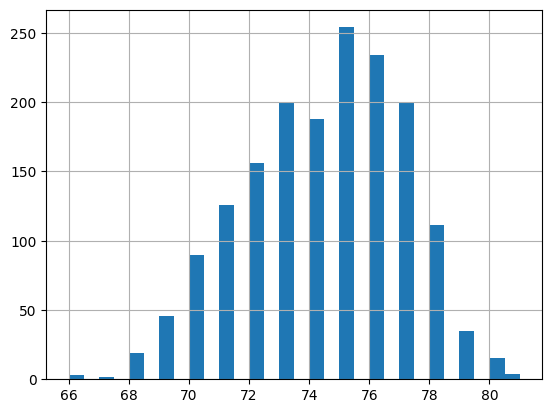

In [96]:
def height_to_inches(height_str):
    feet, inches = map(int, height_str.split("-"))
    total_inches = feet * 12 + inches
    return total_inches

players['heights_inches'] = players['height'].apply(height_to_inches)

players['heights_inches'].hist(bins=30)

In [99]:
import pymc as pm
normal_gamma_toy_model = pm.Model()

with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=70, sigma=5)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=players['heights_inches'])

In [100]:
with normal_gamma_toy_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

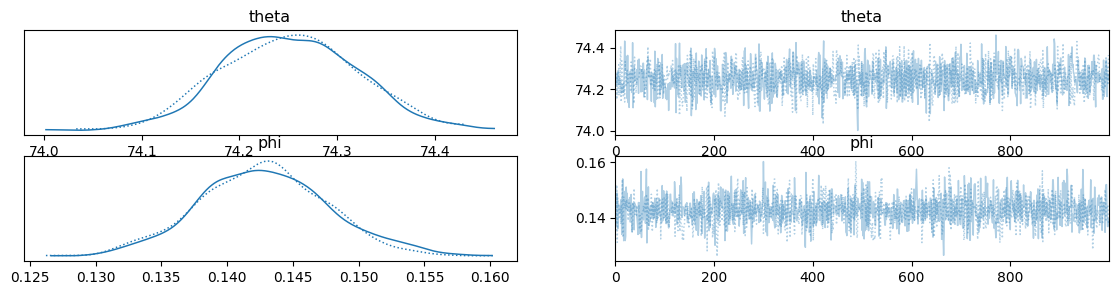

In [102]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]);

Number of Yards achieved per play isn't appropriate for a normal-gamma distribution, since the vast majority of plays happen between 0 and 10 yards, with the distribution skewed as seen below.

<Axes: >

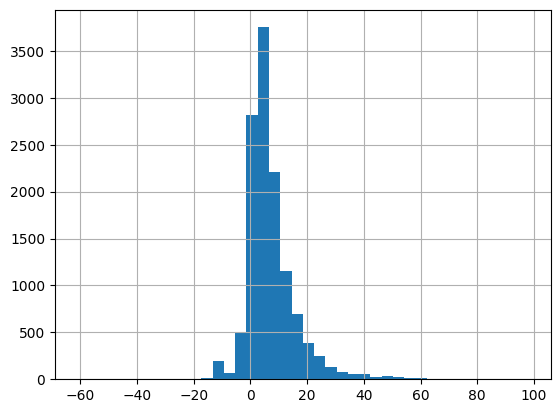

In [103]:
plays['playResult'].hist(bins=40)

In [104]:
import pymc as pm
normal_gamma_toy_model = pm.Model()

with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=5, sigma=2)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=plays['playResult'])

In [63]:
with normal_gamma_toy_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

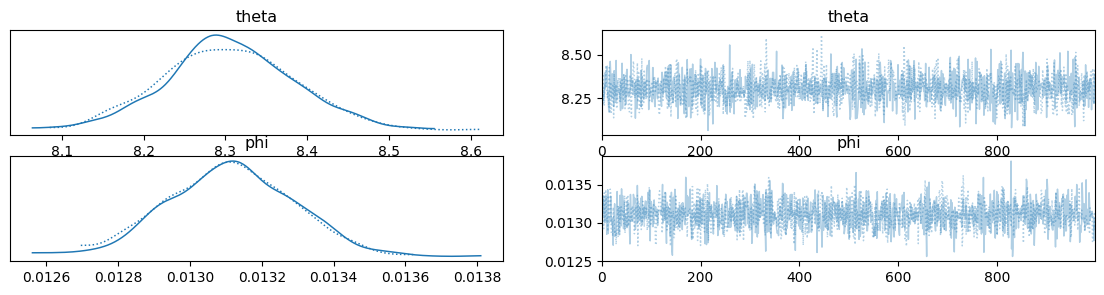

In [64]:
import arviz as az; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2]);

Instead of using a normal-gamma specification, we choose an Cauchy-Gamma specifciation.

In [106]:
import pymc as pm
cauchy_model = pm.Model()

with cauchy_model:
    alpha_val = pm.Gamma("alpha", alpha=1, beta=1)
    beta_val = pm.Gamma("beta", alpha=1, beta=1)
    yards_result = pm.Cauchy("yards", alpha=alpha_val, beta=beta_val, observed=plays['playResult'])

In [107]:
with cauchy_model:
    idata_HMC = pm.sample() # default is the NUTS implementation of HMC

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

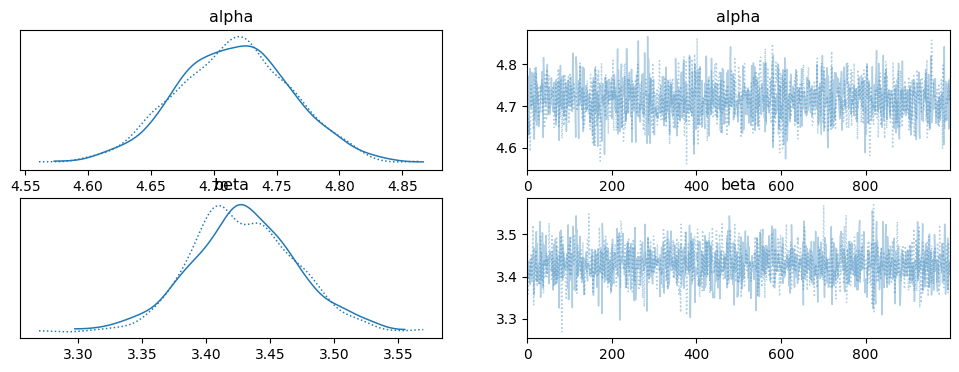

In [108]:
import arviz as az; import matplotlib.pyplot as plt
az.plot_trace(idata_HMC)

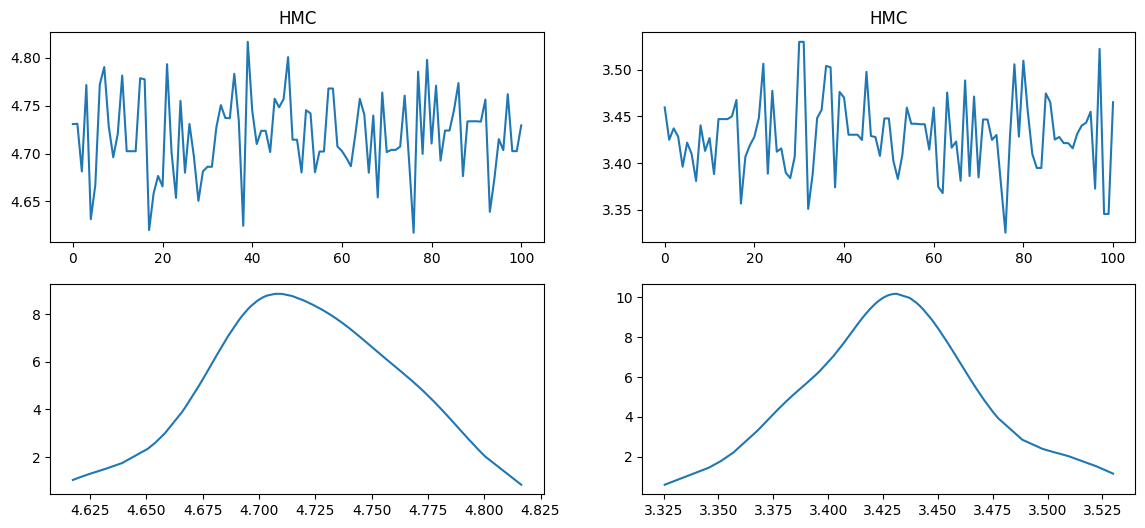

In [112]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt; fig,ax = plt.subplots(2,2, figsize=(14,6))
n_mcmc_samples = 100
mcmc_chain = idata_HMC.posterior["alpha"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted = sorted(mcmc_chain)
mcmc_chain_2 = idata_HMC.posterior["beta"].sel(chain=0, draw=slice(0, n_mcmc_samples)).values; mcmc_chain_sorted_2 = sorted(mcmc_chain_2)
ax[0,0].plot(mcmc_chain);
ax[0,0].set_title("HMC");
ax[1,0].plot(mcmc_chain_sorted,gaussian_kde(mcmc_chain_sorted)(mcmc_chain_sorted));
ax[0,1].plot(mcmc_chain_2);
ax[0,1].set_title("HMC");
ax[1,1].plot(mcmc_chain_sorted_2,gaussian_kde(mcmc_chain_sorted_2)(mcmc_chain_sorted_2));

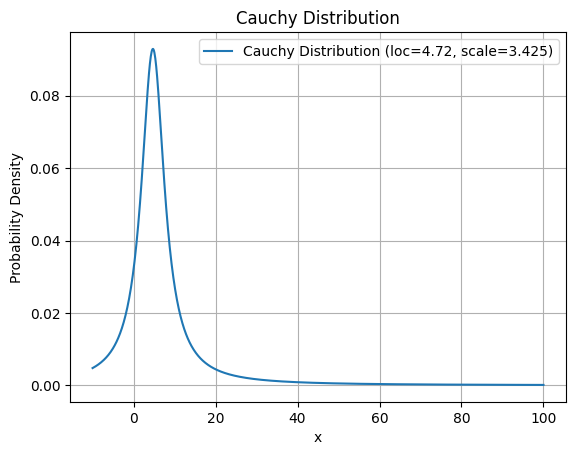

In [115]:
from scipy.stats import cauchy
import numpy as np

# Define parameters for the Cauchy distribution
loc = 4.72  # Location parameter (median)
scale = 3.425  # Scale parameter (half-width at half-maximum)

# Generate a range of x values
x = np.linspace(-10, 100, 1000)

# Calculate the probability density function (PDF) for each x value
pdf = cauchy.pdf(x, loc, scale)

# Plot the Cauchy distribution
plt.plot(x, pdf, label=f'Cauchy Distribution (loc={loc}, scale={scale})')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Cauchy Distribution')
plt.legend()
plt.grid(True)
plt.show()